<a href="https://colab.research.google.com/github/jeanluckei/seminario/blob/main/SentimentAnalysisApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk
!pip install google-play-scraper

import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from google_play_scraper import app

import matplotlib.pyplot as plt
import nltk
from nltk.stem.rslp import RSLPStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('rslp')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report

     |████████████████████████████████| 52 kB 1.5 MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-1.0.2-py3-none-any.whl size=24393 sha256=c576ba030ff37ec19c8ff610aa7d680464082142358f5080a99f50eb131f7e32
  Stored in directory: /root/.cache/pip/wheels/98/99/eb/bbb9d24a5c526980647efc10336eaaeffcf07749f581111128
Successfully built google-play-scraper
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [2]:
# Método responsável por aplicar as transformações necessárias para melhorar
# a qualidade dos textos analisados.
def preprocess(textdata):
    processedText = []
    
    # Lematização
    wordLemm = RSLPStemmer()
    
    # Regex para remoção de urls, usuários, não alfabéticos e repetições
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for text in textdata:
        text = text.lower()
        
        # Substituindo cada possível url por ' URL'
        text = re.sub(urlPattern,' URL',text)
        
        # Substituindo os emojis pelos seus valores
        for emoji in emojis.keys():
            text = text.replace(emoji, "EMOJI" + emojis[emoji])        
        
        # Substituindo o @nomeusuario por 'USER'.
        text = re.sub(userPattern,' USER', text)        
        
        # Removendo todos textos não alfabéticos
        text = re.sub(alphaPattern, " ", text)
        
        # Substituindo repetições de caracteres excessivas
        text = re.sub(sequencePattern, seqReplacePattern, text)

        textwords = ''
        for word in text.split():
            # Verificando se a palavra não é uma stopword
            if word not in stopwords:
                # Se não, verificar se tem 2 ou mais chars e lematizar
                if len(word) >= 2:
                    # Lematização das palavras
                    word = wordLemm.stem(word)
                    textwords += (word+' ')
            
        processedText.append(textwords)
        
    return processedText

In [3]:
# Definindo os emojis que serão substituídos pelos seus significados
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

#Criando a lista de stopwords
# stopwordlist  = stopwords.words('portuguese')
stopwords=nltk.corpus.stopwords.words('portuguese')
stopwords = list(set(stopwords))

In [4]:
def predict(vectoriser, model, text):
    # Prediz o sentimento
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Monta a lista dos sentimmentos preditos
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Gera um pandas df com os dados
    df = pd.DataFrame(data, columns = ['Texto','Sentimento'])
    df = df.replace([0,1], ["Negativo","Positivo"])
    return df

In [5]:
result = app('com.itau', lang = 'pt', country = 'br')
result

{'adSupported': None,
 'androidVersion': '5.0',
 'androidVersionText': '5.0 ou superior',
 'appId': 'com.itau',
 'comments': ['Aplicativo apresentando não funcionamento em questão a parte de lançamentos futuros, entradas e saídas a dias. Já desinstalei e instalei novamente mas não corrigiu meu problema e é algo que eu gostaria muito que estivesse aparecendo. No próprio aplicativo você tenta fazer coisas simples que não é possível pois não funciona de forma satisfatória. Venho por meio dessa plataforma informar pois no próprio aplicativo não estou conseguindo fazer essa observação.',
  'Mais uma vez eu não consigo abrir o app do Itaú, é complicado porque esses bugs atrapalham para quem depende da conta para movimentá-la. Os apps das fintechs raramente dão esse tipo de problema, espero que o Itaú na qualidade do maior banco do país e um dos maiores do mundo deveria resolver em definitivo esse tipo de problema. Se continuar desse jeito, vou ser obrigado a priorizar outros bancos em detrim

In [10]:
#Baixando todos os reviews do app.
from google_play_scraper import Sort, reviews_all

#Comando para todas as reviews
Reviews = reviews_all('com.itau', lang = 'pt', country = 'br', sort = Sort.NEWEST, sleep_milliseconds = 0)

In [11]:
#Importando pandas.
import pandas as pd

#Transformando os dados em um DataFrame para trabalharmos as análises.
Reviews_Agi = pd.DataFrame(Reviews)

#Verificando a serie de dados.
Reviews_Agi

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHZ4RtqMCIuJeO-pBVZcSFbwY84n86XfOK1rcR...,Milena Sousa,https://play-lh.googleusercontent.com/a/AATXAJ...,ótimo aplicativo .amei 😘,5,0,6.80.0,2021-11-14 22:42:30,None,NaT
1,gp:AOqpTOGhN2TUMyFlGNgCjIG2xnxPiiBy-S4Hx2oblh_...,Wr Moreno,https://play-lh.googleusercontent.com/a-/AOh14...,A última atualização com o tal do itoken simpl...,5,0,6.79.0,2021-11-14 22:07:59,None,NaT
2,gp:AOqpTOHywgLAMoL0f2Ec4XSxc0BqUahijmnGnNlQwRT...,Etelvino Barbosa Filho Barbosa,https://play-lh.googleusercontent.com/a/AATXAJ...,app excelente fácil de usar sem complicações i...,5,0,None,2021-11-14 21:38:24,None,NaT
3,gp:AOqpTOEhfE8hxaKbR1Bxn-aSPUPg2U_VwuyKXXvBnyb...,Manrik Gustavo,https://play-lh.googleusercontent.com/a/AATXAJ...,APP é bom porém algumas funções não estão func...,4,0,6.79.0,2021-11-14 21:27:31,None,NaT
4,gp:AOqpTOGqBr6SPriXIgC9g8_jOuO3fSFTPO8ooLQHQ7r...,Sebastiao Pereira,https://play-lh.googleusercontent.com/a/AATXAJ...,Muito boa,5,0,6.77.0,2021-11-14 21:05:36,None,NaT
...,...,...,...,...,...,...,...,...,...,...
803896,lg:AOqpTOH1s3Ce05l5vxkeBlJoyM54m9WdJ1ALbF6CWaZ...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tem muito oqaue melhorar. So nao apaguei pq te...,1,1,1.2,2010-02-04 13:36:51,None,NaT
803897,lg:AOqpTOENQpL4wRdw3eIJYlQhhegXTmrLsmuFPhrs5h8...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Precisa melhorar bastante a interface, com rec...",2,0,1.01,2010-01-31 18:53:48,None,NaT
803898,lg:AOqpTOEzYHvTg_UgOzsH2BTDeIOgZtOnyBiWcmxcTo0...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,Horrivel.... no droid nao funciona...,1,1,1.01,2010-01-25 00:17:04,None,NaT
803899,lg:AOqpTOHzrbvuYtr4Mh6kvngqdbxGinxTSzrKg8xbU7A...,Um usuário do Google,https://play-lh.googleusercontent.com/EGemoI2N...,No droid nao funciona,1,1,1.2,2010-01-19 22:26:00,None,NaT


In [12]:
Reviews_Agi.drop(['reviewId', 'userName', 'userImage', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'thumbsUpCount'], axis=1, inplace=True)
# Preprocessed = Reviews_Agi[(Reviews_Agi != 3).all(1)]
Reviews_Agi.drop(Reviews_Agi[Reviews_Agi.score == 3].index, inplace=True)
Reviews_Agi.reset_index(drop=True, inplace=True)
Reviews_Agi

,content,score
0,ótimo aplicativo .amei 😘,5
1,A última atualização com o tal do itoken simpl...,5
2,app excelente fácil de usar sem complicações i...,5
3,APP é bom porém algumas funções não estão func...,4
4,Muito boa,5
...,...,...
757693,Tem muito oqaue melhorar. So nao apaguei pq te...,1
757694,"Precisa melhorar bastante a interface, com rec...",2
757695,Horrivel.... no droid nao funciona...,1
757696,No droid nao funciona,1


In [13]:
Reviews_Agi['score'].replace(1, 0, inplace=True)
Reviews_Agi['score'].replace(2, 0, inplace=True)
Reviews_Agi['score'].replace(4, 1, inplace=True)
Reviews_Agi['score'].replace(5, 1, inplace=True)
Reviews_Agi = Reviews_Agi.replace(to_replace='None', value=np.nan).dropna()

In [14]:
Reviews_Agi.head(50)

,content,score
0,ótimo aplicativo .amei 😘,1
1,A última atualização com o tal do itoken simpl...,1
2,app excelente fácil de usar sem complicações i...,1
3,APP é bom porém algumas funções não estão func...,1
4,Muito boa,1
5,Ótimo,1
6,Melhor banco,1
7,Horrivel,0
8,"Abri minha conta online, meu cartão foi roubad...",0
9,Olá pessoal tudo certo espero que sim olha gen...,1


In [15]:
Reviews_Agi.groupby('score').describe()

content                          
        count  unique        top   freq
score                                  
0      154822  143556    Péssimo    619
1      602222  309347  Muito bom  36449

In [16]:
import time
t = time.time()

# Atribuindo os valores da coluna content a uma lista e coluna score a outra
text, score = list(Reviews_Agi['content']), list(Reviews_Agi['score'])

processedtext = preprocess(text)
print(f'Pré-processamento de texto completo.')
print(f'Tempo total: {round(time.time()-t)}s')

Pré-processamento de texto completo.
Tempo total: 240s


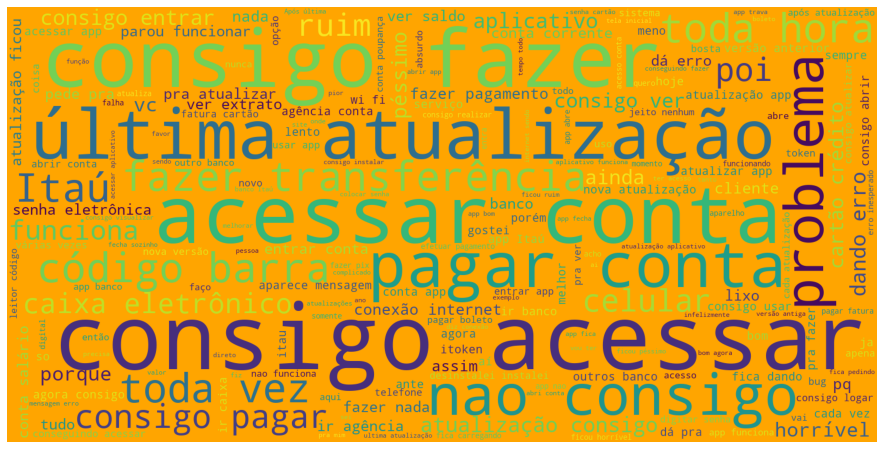

In [17]:
Negative = Reviews_Agi[Reviews_Agi.score == 0]
Neg_Content = Negative['content']
all_neg_content = "".join(c for c in Neg_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='orange', width=1600,                            
                      height=800).generate(all_neg_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

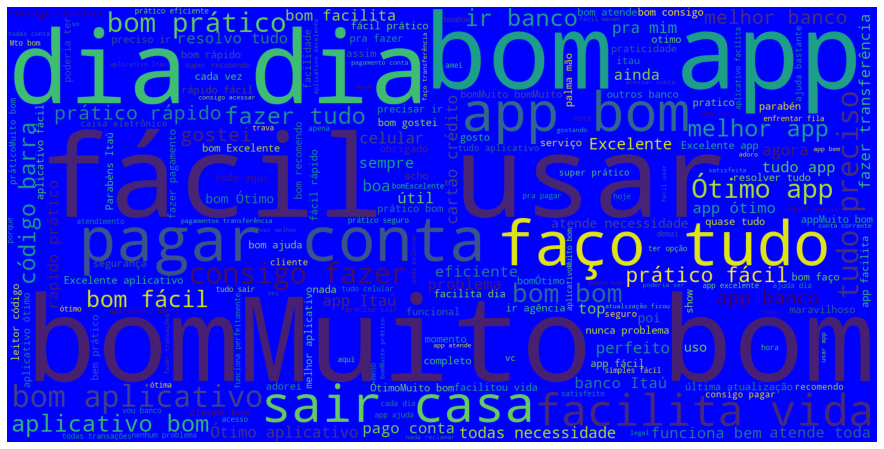

In [18]:
Positive = Reviews_Agi[Reviews_Agi.score == 1]
Pos_Content = Positive['content']
all_pos_content = "".join(c for c in Pos_Content)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='blue', width=1600,                            
                      height=800).generate(all_pos_content)


fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, score, test_size = 0.2, random_state = 0)
print(f'Separação dos dados finalizada.')

Separação dos dados finalizada.


In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=700000)
vectorizer.fit(X_train)
print('Número de features: ', len(vectorizer.get_feature_names()))

Número de features:  446251


In [33]:
# Gerando os datasets X_train e X_test que serão utilizados para treinamento e teste
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
print(f'Dados de treino e teste gerados')

Dados de treino e teste gerados


              precision    recall  f1-score   support

           0       0.87      0.88      0.87     31053
           1       0.97      0.97      0.97    120356

    accuracy                           0.95    151409
   macro avg       0.92      0.92      0.92    151409
weighted avg       0.95      0.95      0.95    151409



Text(0.5, 1.0, 'Matriz de Confusão')

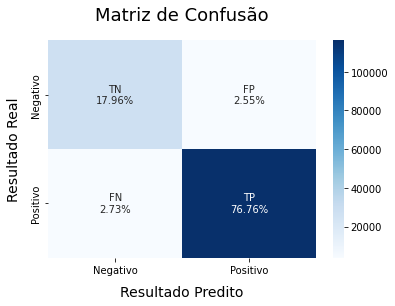

In [34]:
model = LogisticRegression(C = 2, max_iter = 100000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Montando a matriz de confusão pelo sklearn
cf_matrix = confusion_matrix(y_test, y_pred)

# Definindo as categorias da matriz
categories  = ['Negativo','Positivo']
group_names = ['TN','FP', 'FN','TP']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Resultado Predito", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Resultado Real"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Matriz de Confusão", fontdict = {'size':18}, pad = 20)

In [37]:
# Texto de teste
text = ["Este aplicativo é muito ruim, vc deveria liberar mais limite",
        "Este aplicativo é muito bom, tem bastante limite",
        "Muito ruim de usar, lento travaaaa",
        "O app é maravilhoso, funciona mto rápido e tem tudo",
        "lixooooo",
        "Uso sempre e tem bom cartao e interface"]

# Gera um dataframe com os resultados
df = predict(vectorizer, model, text)
print(df)

                                               Texto Sentimento
0  Este aplicativo é muito ruim, vc deveria liber...   Negativo
1   Este aplicativo é muito bom, tem bastante limite   Positivo
2                 Muito ruim de usar, lento travaaaa   Negativo
3  O app é maravilhoso, funciona mto rápido e tem...   Positivo
4                                           lixooooo   Negativo
5            Uso sempre e tem bom cartao e interface   Positivo


In [ ]:
corpus = Negative['content'].tolist()

X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()

top_n = 10

vectorizer = CountVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()
print('Frequency: \n', sorted(list(zip(vectorizer.get_feature_names(), 
                                         X.sum(0).getA1())),
                            key=lambda x: x[1], reverse=True)[:top_n])

Frequency: 
 [('app', 46186), ('consigo', 37476), ('aplicativo', 30321), ('conta', 30205), ('atualização', 22069), ('pra', 20235), ('fazer', 17602), ('nao', 15943), ('acessar', 13869), ('banco', 13149)]


In [ ]:
corpus = Positive['content'].tolist()

X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()

top_n = 10

vectorizer = CountVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)
feature_array = vectorizer.get_feature_names()
print('Frequency: \n', sorted(list(zip(vectorizer.get_feature_names(), 
                                         X.sum(0).getA1())),
                            key=lambda x: x[1], reverse=True)[:top_n])

Frequency: 
 [('bom', 181040), ('app', 82088), ('ótimo', 74380), ('aplicativo', 49381), ('prático', 45505), ('excelente', 38235), ('fácil', 30994), ('tudo', 30244), ('banco', 28648), ('melhor', 24264)]
